In [2]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="quaddelaydb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

quadruple_delay_90conns_1client_0attackers_longrunning_newreala
quadruple_delay_90conns_1client_1attackers_longrunning_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,quadruple_delay_90conns_1client_0attackers_lon...,1,4,1,originserver,microcloud,ubuntu1804-std
1,quadruple_delay_90conns_1client_0attackers_lon...,1,5,4,proxy,microcloud,ubuntu1804-std
2,quadruple_delay_90conns_1client_0attackers_lon...,1,2,5,client1,microcloud,ubuntu1804-std
3,quadruple_delay_90conns_1client_1attackers_lon...,1,10,1,originserver,microcloud,ubuntu1804-std
4,quadruple_delay_90conns_1client_1attackers_lon...,1,12,2,receiver,microcloud,ubuntu1804-std
5,quadruple_delay_90conns_1client_1attackers_lon...,1,7,3,attacker,microcloud,ubuntu1804-std
6,quadruple_delay_90conns_1client_1attackers_lon...,1,11,4,proxy,microcloud,ubuntu1804-std
7,quadruple_delay_90conns_1client_1attackers_lon...,1,8,5,client1,microcloud,ubuntu1804-std


In [4]:
exp_id = "quadruple_delay_90conns_1client_1attackers_longrunning_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 3, 'client1': 5, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 7, 'client1': 8, 'originserver': 10, 'proxy': 11, 'receiver': 12}
{5}
{8}
4


In [5]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,512134,512134,1.642781e+09,1.642781e+09,19.818807
1,client1,1,575,1730,1.642781e+09,1.642781e+09,199.103170
2,originserver,1,27696,55421,1.642781e+09,1.642781e+09,199.460928
3,proxy,1,512712,1538059,1.642781e+09,1.642781e+09,199.915260
4,receiver,1,232478,232478,1.642781e+09,1.642781e+09,82.143990


In [6]:
client_messages_sql = f"""
WITH client_msgs AS (
SELECT
    dn.exp_id,
	e.trial,
	e.observer_id,
    e.message_marker,
	e.observe_timestamp,
	m.src_id, 
    cm.coap_code,
	cm.coap_retransmitted
FROM
	event e
	JOIN deployed_node dn ON dn.dnid = e.observer_id
	JOIN message m ON e.message_id = m.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))}) -- all client dnids
ORDER BY
	e.observe_timestamp
), client_sends AS (
SELECT *
FROM client_msgs
WHERE src_id != {proxy_node_id} -- message source is not the proxy 
), client_recvs AS (
SELECT *
FROM client_msgs
WHERE src_id = {proxy_node_id} -- message source is the proxy 
), msgs_summary AS (
SELECT 
	cm.exp_id,
	cm.trial,
	cm.observer_id,
	cm.message_marker,
	COUNT(cm.*) AS num_observations,
	SUM(CASE WHEN cm.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM 
	client_msgs cm
GROUP BY
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
ORDER BY 
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
), timestamps_summary AS (
SELECT 
	cm.exp_id, 
	cm.trial, 
	cm.observer_id, 
	MIN(observe_timestamp) AS min_observe_timestamp, 
	MAX(observe_timestamp) AS max_observe_timestamp
FROM client_msgs cm
GROUP BY cm.exp_id, cm.trial, cm.observer_id
ORDER BY cm.exp_id, cm.trial, cm.observer_id
), main_table AS (
SELECT 
	cs.exp_id,
	cs.trial,
	cs.observer_id,
    cs.message_marker,
	1e3 * (MAX(cr.observe_timestamp) - MIN(cs.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MAX(cr.observe_timestamp) - MAX(cs.observe_timestamp)) AS rtt_ms_last_transmission,
	-- MIN is ok to use as "first in aggregation group" since all 
	-- values are expected to be the same in the GROUP BY group
	MIN(cs.observe_timestamp) - MIN(min_observe_timestamp) AS send_time_sec,
	MAX(cr.observe_timestamp) - MIN(min_observe_timestamp) AS recv_time_sec,
	MIN(ms.num_observations) AS num_observations,
	MIN(ms.num_retransmissions) AS num_retransmissions
FROM 
	client_sends cs
	LEFT JOIN client_recvs cr
		ON cs.exp_id = cr.exp_id 
		AND cs.trial = cr.trial
		AND cs.observer_id = cr.observer_id
		AND cs.message_marker = cr.message_marker
	JOIN timestamps_summary ts
		ON cs.exp_id = ts.exp_id 
		AND cs.trial = ts.trial
		AND cs.observer_id = ts.observer_id
	, msgs_summary ms
WHERE
	cs.exp_id = ms.exp_id
	AND cs.trial = ms.trial
	AND cs.observer_id = ms.observer_id
	AND cs.message_marker = ms.message_marker
GROUP BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
ORDER BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
), rps_stats AS (
SELECT 
	mt.exp_id,
	mt.trial,
	mt.observer_id,
	COUNT(DISTINCT mt.message_marker) AS num_messages,
	MAX(mt.recv_time_sec) AS last_receive_time_sec,
	MIN(mt.send_time_sec) AS first_send_time_sec,
	COUNT(DISTINCT mt.message_marker) / (MAX(mt.recv_time_sec) - MIN(mt.send_time_sec)) AS average_rps
FROM main_table mt
GROUP BY mt.exp_id, mt.trial, mt.observer_id
)

SELECT mt.*, rs.average_rps, rs.first_send_time_sec, rs.last_receive_time_sec
FROM main_table mt
JOIN rps_stats rs
	ON mt.exp_id = rs.exp_id
	AND mt.trial = rs.trial
	AND mt.observer_id = rs.observer_id
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
con.commit()

rtts_df

,exp_id,trial,observer_id,message_marker,rtt_ms_first_transmission,rtt_ms_last_transmission,send_time_sec,recv_time_sec,num_observations,num_retransmissions,average_rps,first_send_time_sec,last_receive_time_sec
0,quadruple_delay_90conns_1client_1attackers_lon...,1,8,1,494.801760,494.801760,0.000000,0.494802,3,0,2.887962,0.0,199.102335
1,quadruple_delay_90conns_1client_1attackers_lon...,1,8,2,205.862045,205.862045,0.507020,0.712882,3,0,2.887962,0.0,199.102335
2,quadruple_delay_90conns_1client_1attackers_lon...,1,8,3,204.847097,204.847097,0.715060,0.919907,3,0,2.887962,0.0,199.102335
3,quadruple_delay_90conns_1client_1attackers_lon...,1,8,4,205.549002,205.549002,0.922189,1.127738,3,0,2.887962,0.0,199.102335
4,quadruple_delay_90conns_1client_1attackers_lon...,1,8,5,204.925060,204.925060,1.129945,1.334870,3,0,2.887962,0.0,199.102335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,quadruple_delay_90conns_1client_1attackers_lon...,1,8,512705,202.064037,202.064037,198.291370,198.493434,3,0,2.887962,0.0,199.102335
571,quadruple_delay_90conns_1client_1attackers_lon...,1,8,512706,202.126980,202.126980,198.494274,198.696401,3,0,2.887962,0.0,199.102335
572,quadruple_delay_90conns_1client_1attackers_lon...,1,8,512707,202.087879,202.087879,198.697274,198.899362,3,0,2.887962,0.0,199.102335
573,quadruple_delay_90conns_1client_1attackers_lon...,1,8,512708,202.146769,202.146769,198.900188,199.102335,3,0,2.887962,0.0,199.102335


In [7]:
rtts_df[["rtt_ms_first_transmission", "rtt_ms_last_transmission"]].describe()

,rtt_ms_first_transmission,rtt_ms_last_transmission
count,574.000000,574.000000
mean,345.714544,266.491563
std,2726.942612,1185.296879
min,201.930285,201.930285
25%,202.101409,202.101409
50%,202.142477,202.142477
75%,202.201605,202.201605
max,64175.903082,27858.794928


<IPython.core.display.Javascript object>


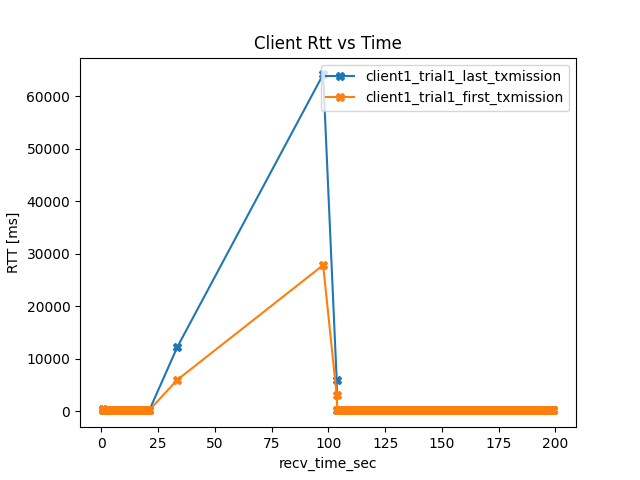

In [8]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
kind = "line"
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        
        # RTT since first transmission
        last_txmission = label + "_last_txmission"
        plot_args = {"kind": kind,
                     "x": "recv_time_sec",
                     "y": "rtt_ms_first_transmission",
                     "label": last_txmission,
                     "marker": 'X'}
        if ax:
            plot_args += {"ax": ax}
        
        ax = client_trial_df.plot(**plot_args)
        plot_args["ax"] = ax

        # RTT since last transmission
        first_txmission = label + "_first_txmission"
        plot_args["label"] = first_txmission
        plot_args["y"] = "rtt_ms_last_transmission"
        ax = client_trial_df.plot(**plot_args)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


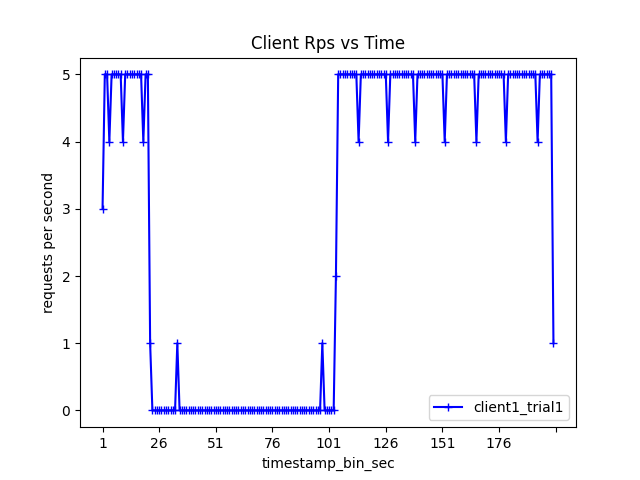

,recv_time_sec,packets_per_second,observer_id,timestamp_bin_sec
0,1,3,8.0,1
1,2,5,8.0,2
2,3,5,8.0,3
3,4,4,8.0,4
4,5,5,8.0,5
...,...,...,...,...
195,196,5,8.0,196
196,197,5,8.0,197
197,198,5,8.0,198
198,199,5,8.0,199


In [66]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["recv_time_sec"].min()
    
    max_recv_time_sec = int(max(np.ceil(trial_df["recv_time_sec"])))
    bins = list(range(0, max_recv_time_sec + 1, 1))
    time_stats_df = trial_df.groupby(\
        pd.cut(trial_df["recv_time_sec"], bins=bins, labels=bins[1:], include_lowest=True)).agg(
            packets_per_second=("observer_id", "count"),
            observer_id=("observer_id", "first"),
        )\
    .reset_index()
    time_stats_df["timestamp_bin_sec"] = time_stats_df["recv_time_sec"]
    
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[(time_stats_df["observer_id"] == src_id) | ~(pd.notnull(time_stats_df["observer_id"]))]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label, marker="+")

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


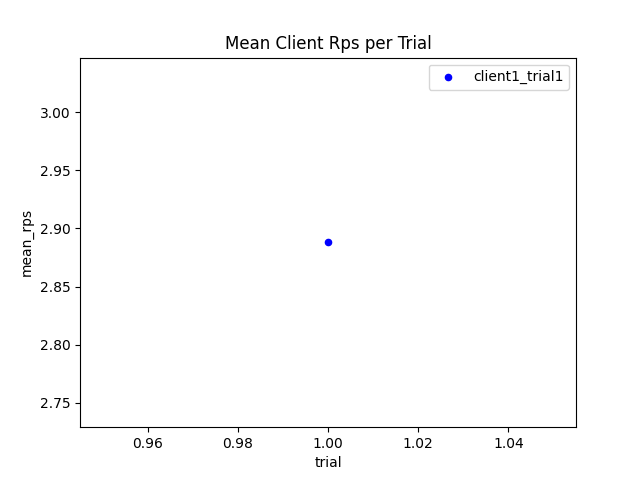

   trial  mean_rps
0      1  2.887962


,observer_id,trial,mean_rps
0,8,1,2.887962


In [65]:
gdf = rtts_df.groupby(by=["observer_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["observer_id"].unique(), start=1):
        cdf = tdf[tdf["observer_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

gdf

In [68]:
attack_dbg_sql = f"""

WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["proxy"]} -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["originserver"]} AND dst_id = {node_map_node_id["proxy"]} -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["receiver"]} AND dst_id = {node_map_node_id["proxy"]} -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["originserver"]} -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = {node_map_node_id["proxy"]} AND dst_id = {node_map_node_id["originserver"]} -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["receiver"]} -- receiver is observer
), experiment_timestamps AS (
SELECT 
	MIN(x.observe_timestamp) AS min_timestamp,
	MAX(x.observe_timestamp) AS max_timestamp
FROM 
	event x 
WHERE 
	x.observer_id = {node_map_dnid["proxy"]} OR x.observer_id IN ({','.join(map(str, client_dnids))}) -- proxy or client
), main_table AS (
SELECT 
	dn.exp_id,
	e.trial,
	e.message_marker,
	
	r.coap_type,
	r.coap_code,
	r.coap_retransmitted,
	
	sfp.src_id AS sfp_src_id,
	sfp.dst_id AS sfp_dst_id,
	
	e.observe_timestamp - min_timestamp   AS a_observe_timestamp,
	pfa.observe_timestamp - min_timestamp AS pfa_observe_timestamp,
	sfp.observe_timestamp - min_timestamp AS sfp_observe_timestamp,
	pfs.observe_timestamp - min_timestamp AS pfs_observe_timestamp,
	r.observe_timestamp - min_timestamp   AS r_observe_timestamp,
	
	1e3 * (pfa.observe_timestamp - e.observe_timestamp)   AS attacker_to_proxy_ms,
	1e3 * (sfp.observe_timestamp - pfa.observe_timestamp) AS proxy_to_server_ms,
	1e3 * (pfs.observe_timestamp - sfp.observe_timestamp) AS server_to_proxy_ms,
	1e3 * (r.observe_timestamp   - pfs.observe_timestamp) AS proxy_to_receiver_ms,
	1e3 * (r.observe_timestamp   - e.observe_timestamp)   AS attacker_to_receiver_ms
FROM
	event e
	JOIN deployed_node dn             ON dn.dnid            = e.observer_id
	LEFT JOIN proxy_from_attacker pfa ON pfa.message_marker  = e.message_marker
	LEFT JOIN server_from_proxy sfp   ON sfp.message_marker = e.message_marker
	LEFT JOIN proxy_from_server pfs   ON pfs.message_marker = e.message_marker
	LEFT JOIN receiver r              ON r.message_marker   = e.message_marker
	, experiment_timestamps
WHERE 
	e.observer_id = {node_map_dnid["attacker"]} -- attacker is observer for e
), per_message_table AS (
-- Using MIN as an aggregator is perfectly fine for those values which
-- we expect to be the same across values in a groupby group
SELECT
	mmt.exp_id,
	mmt.trial,
	mmt.message_marker,
	COUNT(mmt.message_marker) AS message_occurrence,
	(ARRAY_AGG(coap_code))[1] AS coap_code,
	(ARRAY_AGG(coap_code)) AS coap_codes,
    
	MIN(a_observe_timestamp) AS a_observe_timestamp,
	
	MIN(attacker_to_receiver_ms) AS min_attacker_to_receiver_ms,
	MAX(attacker_to_receiver_ms) AS max_attacker_to_receiver_ms,
	
	(MIN(attacker_to_proxy_ms) 
	 + MIN(proxy_to_server_ms) 
	 + MIN(server_to_proxy_ms) 
	 + MIN(proxy_to_receiver_ms)) AS min_composite_attacker_to_receiver_ms,
	(MAX(attacker_to_proxy_ms) 
	 + MAX(proxy_to_server_ms) 
	 + MAX(server_to_proxy_ms) 
	 + MAX(proxy_to_receiver_ms)) AS max_composite_attacker_to_receiver_ms,
	
	MIN(attacker_to_proxy_ms) AS min_attacker_to_proxy_ms,
	MIN(proxy_to_server_ms) AS min_proxy_to_server_ms,
	MIN(server_to_proxy_ms) AS min_server_to_proxy_ms,
	MIN(proxy_to_receiver_ms) AS min_proxy_to_receiver_ms,

	MAX(attacker_to_proxy_ms) AS max_attacker_to_proxy_ms,
	MAX(proxy_to_server_ms) AS max_proxy_to_server_ms,
	MAX(server_to_proxy_ms) AS max_server_to_proxy_ms,
	MAX(proxy_to_receiver_ms) AS max_proxy_to_receiver_ms
FROM 
	main_table mmt
GROUP BY 
	mmt.exp_id, mmt.trial, mmt.message_marker, attacker_to_receiver_ms
ORDER BY
	mmt.exp_id, mmt.trial, mmt.message_marker
), message_summary AS (
	SELECT
		COUNT(DISTINCT x.message_marker) AS num_unique_messages,
		COUNT(x.message_marker) AS num_messages
	FROM
		per_message_table x
)

SELECT 
	ms.*,
	pmt.*
FROM
	message_summary ms,
	per_message_table pmt
;
"""

adbgdf = pd.read_sql_query(attack_dbg_sql, con)
adbgdf["sent_time_ms"] = adbgdf["a_observe_timestamp"]
adbgdf.sort_values(by="sent_time_ms", inplace=True)
con.commit()

adbgdf

,num_unique_messages,num_messages,exp_id,trial,message_marker,message_occurrence,coap_code,coap_codes,a_observe_timestamp,min_attacker_to_receiver_ms,...,max_composite_attacker_to_receiver_ms,min_attacker_to_proxy_ms,min_proxy_to_server_ms,min_server_to_proxy_ms,min_proxy_to_receiver_ms,max_attacker_to_proxy_ms,max_proxy_to_server_ms,max_server_to_proxy_ms,max_proxy_to_receiver_ms,sent_time_ms
0,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,102,2,content,"[content, content]",20.943531,635.797977,...,635.808229,3.638744,298.524857,106.338024,227.286100,3.648996,298.535109,106.338024,227.286100,20.943531
1,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,103,2,content,"[content, content]",20.943587,635.938168,...,635.941029,3.597021,298.519135,106.298208,227.520943,3.599882,298.521996,106.298208,227.520943,20.943587
2,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,104,2,content,"[content, content]",20.943588,635.917902,...,635.922670,3.742933,298.629284,106.158018,227.382898,3.747702,298.634052,106.158018,227.382898,20.943588
3,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,105,2,content,"[content, content]",20.943831,635.218859,...,635.229588,3.750086,300.669909,105.756283,225.031853,3.760815,300.680637,105.756283,225.031853,20.943831
4,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,106,2,content,"[content, content]",20.943832,635.484934,...,635.487795,3.765106,300.363064,105.746031,225.607872,3.767967,300.365925,105.746031,225.607872,20.943832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512129,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,512233,2,None,"[None, None]",40.762156,NaN,...,NaN,3.895760,NaN,NaN,NaN,3.896713,NaN,NaN,NaN,40.762156
512130,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,512234,2,None,"[None, None]",40.762193,NaN,...,NaN,3.860950,NaN,NaN,NaN,3.861904,NaN,NaN,NaN,40.762193
512131,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,512235,2,None,"[None, None]",40.762230,NaN,...,NaN,3.824949,NaN,NaN,NaN,3.826141,NaN,NaN,NaN,40.762230
512132,512134,512134,quadruple_delay_90conns_1client_1attackers_lon...,1,512236,2,None,"[None, None]",40.762291,NaN,...,NaN,3.766060,NaN,NaN,NaN,3.767014,NaN,NaN,NaN,40.762291


In [69]:
coap_codes = dict()
def scan_coap_codes(row):
    for cc in row["coap_codes"]:
        coap_codes[cc] = 1 + coap_codes.setdefault(cc, 0)

adbgdf.apply(scan_coap_codes, axis=1)

print(coap_codes)

adbgdf.groupby(by="message_occurrence").nunique()

{'content': 54162, None: 558531, 'bad_gateway': 410328}


TypeError: unhashable type: 'list'

In [ ]:
# Plot attacker rtt vs time

ax = None
x="sent_time_ms"
ys=["min_attacker_to_receiver_ms"]
kind="line"

for coap_code in coap_codes:
    if coap_code is None:
        continue
    for y in ys:
        _df = adbgdf[(pd.notna(adbgdf["coap_code"])) & (adbgdf["coap_code"].str.contains(coap_code))]
        for mc in _df.message_occurrence.unique():
            mcdf = _df[_df["message_occurrence"] == mc]
            ax = mcdf.plot(
                **{"kind": kind,
                   "x": x,
                   "y": y,
                   "ax": ax,
                   "marker": "X",
                   "label": f"{mc}_{y}_{coap_code}"})
    
ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
ax.legend()
plt.show()

In [ ]:
# Plot the duration of different stages of the attack messages

x="sent_time_ms"
kind="scatter"
ax = None
ax = adbgdf.plot(kind=kind, x=x, y="attacker_to_proxy_ms", ax=ax, label="attacker_to_proxy_ms", color='red')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_server_ms", ax=ax, label="proxy_to_server_ms", color='green')
ax = adbgdf.plot(kind=kind, x=x, y="server_to_proxy_ms", ax=ax, label="server_to_proxy_ms", color='blue')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_receiver_ms", ax=ax, label="proxy_to_receiver_ms", color='black')

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()